# IMPORT LIBRARIES

In [1]:
# Import necessary libraries
import BiQ_Common_Fxns as BiQ
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation and analysis
import matplotlib.pyplot as plt  # for creating plots
import itertools  # for iterators and looping functions
import math  # for mathematical operations
import statsmodels.formula.api as smf  # for statistical modeling
import statsmodels.api as sm  # for statistical analysis and modeling
from itertools import combinations

# EXTRACT DATA FROM WORKSHEET

In [2]:
# Initialize a global variable to store DataFrame read from Excel
global_df = None

def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    global global_df  # Access the global DataFrame variable
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        
        # Identify categorical columns based on 'Data Type' column
        categorical_cols = df.loc[df['Data Type'] == 'Categorical', 'Factor'].tolist()
        
        # Convert identified categorical columns to strings
        df[categorical_cols] = df[categorical_cols].astype(str)
        
        global_df = df.copy()  # Assign the modified DataFrame to the global variable

        # Print the data types after conversion
        print(df.dtypes)
        
        return global_df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def extract_factor_values(df, factors_column):
    """Extracts unique factor values from the specified column."""
    try:
        factor_values = df[factors_column].dropna().unique()  # Extract unique factor values from specified column
        return factor_values  # Return the unique factor values
    except Exception as e:
        print(f"Error extracting factor values: {e}")  # Print error message if extraction fails
        return None  # Return None if an error occurs


def process_excel_file(file_paths):
    """Processes the selected Excel file."""
    if file_paths:  # Check if file paths are provided
        results_file = file_paths[0]  # Get the first file path from the list
        factors_column = 'Factor'  # Define the column name containing factors
        df = read_excel_file(results_file)  # Read Excel file into DataFrame
        if df is not None:  # Check if DataFrame is successfully loaded
            factor_values = extract_factor_values(df, factors_column)  # Extract factor values from DataFrame
            return df, factor_values  # Return the DataFrame and factor values
    return None, None  # Return None for DataFrame and factor values if file loading fails

def main():
    file_paths, _ = BiQ.open_file_dialog()  # Open a file dialog to select Excel file(s)

    if file_paths:  # Check if file paths are provided
        results_file = file_paths[0]  # Get the first file path from the list
        df = read_excel_file(results_file)  # Read Excel file into DataFrame
        if df is not None:  # Check if DataFrame is successfully loaded
            # Perform additional processing logic here
            pass
    else:
        print("No file selected.")  # Print message if no file is selected

    # print the global DataFrame
    print(global_df)  # print the global DataFrame

# Call the main function if the script is executed directly
if __name__ == "__main__":
    main()


Selected files:
C:/Users/ChrisSaid/Boulder BioMed/Engineering - Documents/Cerapedics/3- Consultant Working Documents/Pulverizing Sieving/Sieve Counterweight Adjustment Study/DOE Worksheet (GAP1 v Profile).xlsx [DOE Worksheet (GAP1 v Profile).xlsx]
Factor        object
Levels       float64
Data Type     object
UCW            int64
LCW           object
LA            object
Results      float64
dtype: object
   Factor  Levels    Data Type  UCW LCW LA    Results
0     UCW     3.0   Continuous    0   0  0  12.240933
1     LCW     2.0  Categorical    1   0  0   2.014792
2      LA     2.0  Categorical    2   0  0   3.170645
3     NaN     NaN          NaN    0   1  0  11.873921
4     NaN     NaN          NaN    1   1  0   3.315481
5     NaN     NaN          NaN    2   1  0   4.666904
6     NaN     NaN          NaN    0   0  1  32.426598
7     NaN     NaN          NaN    1   0  1   2.193318
8     NaN     NaN          NaN    2   0  1   4.310652
9     NaN     NaN          NaN    0   1  1   2.0941

# ANALYSIS

## MAIN EFFECTS PLOT

In [31]:

def main_effects_plot(df):
    """Plots main effects based on the DataFrame."""
    if df is None:
        print("DataFrame is empty.")
        return
    
    factors_column = 'Factor'
    levels_column = 'Levels'
    results_column = 'Results'
    data_type_column = 'Data Type'
    
    print(f"Original DataFrame:\n{df}\n")
    
    # Extract unique factor values from the 'Factor' column
    factors_info = df[df[factors_column].notnull()].set_index(factors_column).to_dict(orient='index')
    print(f"Factors Information: {factors_info}\n")
    
    # Calculate main effects
    main_effects = {}
    for factor, info in factors_info.items():
        levels = info.get(levels_column, 0)
        data_type = info.get(data_type_column, '')
        print(f"Factor: {factor}, Levels: {levels}, Data Type: {data_type}")
        main_effect_values = []
        
        if data_type == 'Continuous':
            mean_all = df[results_column].mean()
            for level in range(int(levels)):
                mean_level = df[(df[factor] == level)][results_column].mean()
                main_effect_values.append(mean_level - mean_all)
            main_effects[factor] = main_effect_values
            print(f"Main effects for {factor}: {main_effect_values}\n")
        elif data_type == 'Categorical':
            for level in range(int(levels)):
                mean_level = df[(df[factor] == level)][results_column].mean()
                main_effect_values.append(mean_level - df[results_column].mean())  # Calculate main effect relative to mean
            main_effects[factor] = main_effect_values
            print(f"Main effects for {factor}: {main_effect_values}\n")
        else:
            print(f"No main effects calculated for {factor} due to unknown data type.\n")
    
    # Plot main effects
    if main_effects:
        fig, ax = plt.subplots(figsize=(12, 6))
        x_values = range(len(main_effects))  # x positions for bars

        bars = ax.bar(x_values, [sum(values) if isinstance(values, list) else values for values in main_effects.values()], alpha=0.7)
        
        # Annotate bars with their values
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

        # Set x-axis labels and title
        ax.set_xticks(x_values)
        ax.set_xticklabels(main_effects.keys())
        ax.set_xlabel('Factors')
        ax.set_ylabel('Main Effect')
        ax.set_title('Main Effects Plot')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("No main effects calculated for plotting.")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Original DataFrame:
   Factor  Levels    Data Type  UCW LCW LA    Results
0     UCW     3.0   Continuous    0   0  0  12.240933
1     LCW     2.0  Categorical    1   0  0   2.014792
2      LA     2.0  Categorical    2   0  0   3.170645
3     NaN     NaN          NaN    0   1  0  11.873921
4     NaN     NaN          NaN    1   1  0   3.315481
5     NaN     NaN          NaN    2   1  0   4.666904
6     NaN     NaN          NaN    0   0  1  32.426598
7     NaN     NaN          NaN    1   0  1   2.193318
8     NaN     NaN          NaN    2   0  1   4.310652
9     NaN     NaN          NaN    0   1  1   2.094128
10    NaN     NaN          NaN    1   1  1   2.754399
11    NaN     NaN          NaN    2   1  1   4.346277

Factors Information: {'UCW': {'Levels': 3.0, 'Data Type': 'Continuous', 'UCW': 0, 'LCW': '0', 'LA': '0', 'Results': 12.240932642487046}, 'LCW': {'Levels': 2.0, 'Data Type': 'Categorical', 'UCW': 1, 'LCW': '0', 'LA': '0', 'Results': 2.014792144861005}, 'LA': {'Levels': 2.0, 'Da

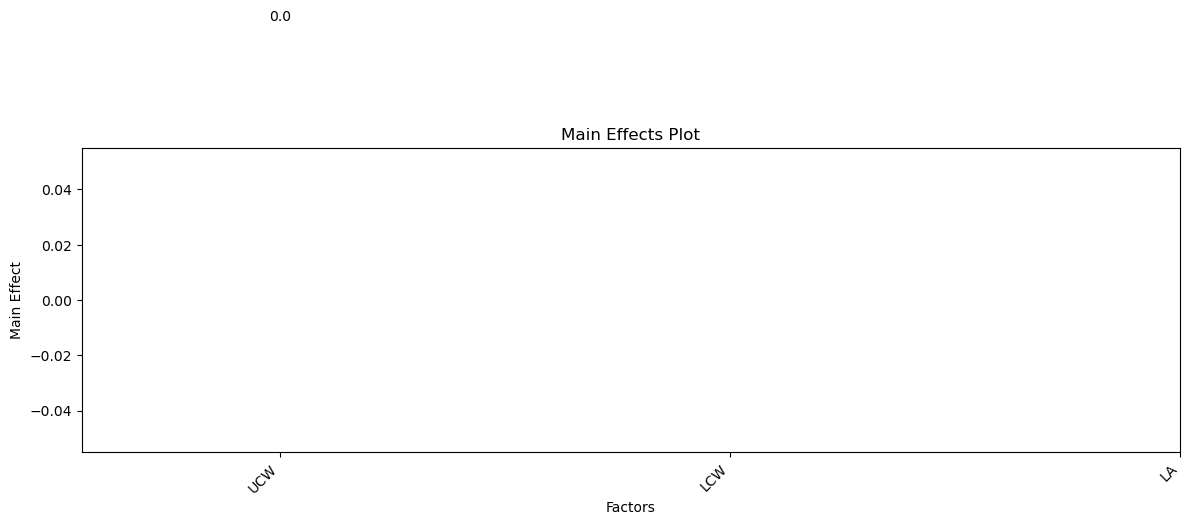

In [32]:
# Call the function
main_effects_plot(global_df)

## INTERACTION PLOTS

### INTERACTION EFFECTS PLOT

In [ ]:
def interaction_effects_plot(df, results_column, factor_column='Factor'):
    """
    Plots interaction effects based on the DataFrame, results_column, and factor_column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - results_column (str): Name of the column containing the results.
    - factor_column (str): Name of the column containing the factor values. Default is 'Factor'.
    """
    if df is None or df.empty:
        print("DataFrame is empty.")
        return

    # Extract factor values and filter columns based on factor values
    factor_values = df[factor_column].dropna().unique()
    interest_columns = [col for col in df.columns if col not in [factor_column, results_column] and col in factor_values]

    # Generate interactions based on interest_columns
    interactions = list(itertools.combinations(interest_columns, 2))

    interaction_labels = []
    interaction_effects = []

    # Calculate interaction effects
    for interaction in interactions:
        try:
            # Group data by the current interaction and calculate mean for results_column
            grouped = df.groupby(list(interaction))[results_column].mean()
            # Calculate interaction effect
            interaction_effect = (grouped[(1, 1)] - grouped[(1, -1)] - grouped[(-1, 1)] + grouped[(-1, -1)]) / 2
            # Append interaction label and effect to respective lists
            interaction_labels.append(f"{interaction[0]} x {interaction[1]}")
            interaction_effects.append(interaction_effect)
        except KeyError:
            # Handle KeyError if the current interaction is not found in the data
            print(f"Interaction {interaction} not found in the data. Skipping.")
            continue

    if interaction_labels and interaction_effects:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(interaction_labels, interaction_effects)

        for i, v in enumerate(interaction_effects):
            ax.text(i, v + 0.01 * max(interaction_effects), round(v, 2), ha='center', va='bottom')

        ax.set_ylabel("Interaction Effect")
        ax.set_title("Two-way Interaction Effects")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("No valid interaction effects found.")

In [ ]:
interaction_effects_plot(global_df, 'Results')

### INTERACTION POINT PLOT

In [ ]:
def interaction_point_plot(df, results_column, factor_column):
    """
    Plots interaction point plot based on the DataFrame, results_column, and factor_column.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - results_column (str): Name of the column containing the results.
    - factor_column (str): Name of the column containing the factor values.
    """
    if df is None or df.empty:  # Check if DataFrame is empty
        print("DataFrame is empty.")
        return
    
    # Filter columns based on values present in the factor_column
    factor_values = df[factor_column].dropna().unique()
    factors = [col for col in df.columns if col != factor_column and col != results_column and col in factor_values]
    
    print("Factor Values:", factor_values)
    print("All Columns:", df.columns)
    print("Filtered Factors:", factors)
    
    # Filter combinations to include only those involving factors
    interactions = list(itertools.combinations(factors, 2))

    if not interactions:
        print("No valid interactions found based on filtering criteria.")
        return

    print("Valid Interactions:", interactions)
    

    cols = 3
    rows = math.ceil(len(interactions) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10*rows/3))

    for idx, interaction in enumerate(interactions):
        row = idx // cols
        col = idx % cols
        ax = axs[row, col] if rows > 1 else axs[col]

        for level in [-1, 1]:
            subset = df[df[interaction[0]] == level]
            ax.plot(subset[interaction[1]].unique(), subset.groupby(interaction[1])[results_column].mean(), 'o-', label=f'{interaction[0]} = {level}')

        ax.set_title(f'{interaction[0]} x {interaction[1]}')
        ax.legend()
        ax.grid(True)

    for idx in range(len(interactions), rows*cols):
        row = idx // cols
        col = idx % cols
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
interaction_point_plot(global_df, 'Results', 'Factor')

## ANOVA TABLE / MODEL SUMMARY

In [ ]:
def generate_anova_table(df):
    # Check and clean column names
    df.columns = df.columns.str.strip()

    # Check if 'Results' column exists in the DataFrame
    if 'Results' not in df.columns:
        raise ValueError("'Results' column not found in the DataFrame.")

    # Print the DataFrame to check data processing
    print("Processed DataFrame:")
    print(df)

    # Separate categorical and continuous variables based on 'Data Type'
    cat_cols = df.loc[df['Data Type'] == 'Categorical', 'Factor'].tolist()

    # Construct the formula string
    formula_parts = []
    if cat_cols:
        formula_parts.append(' + '.join([f'C({col})' for col in cat_cols]))

    if not formula_parts:
        raise ValueError("No categorical variables found in the DataFrame.")

    formula_string = f'Results ~ {" + ".join(formula_parts)}'

    # Create interactions between factors directly in the formula
    interactions = list(combinations(cat_cols, 2))
    interaction_terms = [f'C({f1}):C({f2})' for f1, f2 in interactions]
    formula_string += ' + ' + ' + '.join(interaction_terms)

    print("\nConstructed Formula:", formula_string)

    try:
        # Fit the model using the formula
        model = smf.ols(formula_string, data=df).fit()
        print(model.summary())
        return model
    except Exception as e:
        print("Error occurred during model generation:", e)

        # Call the function with your DataFrame
try:
    model = generate_anova_table(global_df)
except Exception as e:
    print("Error occurred during model generation:", e)

## MODEL DIAGNOSTICS

In [ ]:
def diagnostic_plots(model):
    # Extract residuals and predicted values from the model
    residuals = model.resid
    predicted = model.fittedvalues
    
    # Create subplots with one row and three columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # Creating a figure and axes for subplots
    
    # Residuals vs Fits
    axs[0].scatter(predicted, residuals, edgecolors='k', facecolors='none')  # Scatter plot of predicted vs residuals
    axs[0].axhline(y=0, color='k', linestyle='dashed', linewidth=1)  # Horizontal line at y=0
    axs[0].set_title('Residuals vs. Fits')  # Setting title for the subplot
    axs[0].set_xlabel('Fit values')  # Setting label for x-axis
    axs[0].set_ylabel('Residuals')  # Setting label for y-axis
    
    # Residuals vs. Order (Order of Data Collection)
    axs[1].scatter(range(len(residuals)), residuals, edgecolors='k', facecolors='none')  # Scatter plot of residuals vs runs
    axs[1].axhline(y=0, color='k', linestyle='dashed', linewidth=1)  # Horizontal line at y=0
    axs[1].set_title('Residuals vs. Order')  # Setting title for the subplot
    axs[1].set_xlabel('Order')  # Setting label for x-axis
    axs[1].set_ylabel('Residuals')  # Setting label for y-axis
    
    # Q-Q plot
    sm.qqplot(residuals, line='45', fit=True, ax=axs[2])  # Q-Q plot of residuals
    axs[2].set_title('Q-Q Plot')  # Setting title for the subplot
    
    plt.tight_layout()  # Adjusting layout to prevent overlap
    plt.show()  # printing the plots

In [ ]:
diagnostic_plots(model)

## 3D SURFACE PLOTS

### HELD VALUE = 1

In [ ]:

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_3D_surface(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = df['Factor'].unique()

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4), subplot_kw={'projection': '3d'})
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Handle missing values and encode categorical variables
        df_encoded = df.fillna({'Data Type': 'Unknown'})  # Fill missing Data Type values
        df_encoded = pd.get_dummies(df_encoded, columns=['Data Type'])  # One-hot encode categorical variables

        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(df_encoded[x_name].min(), df_encoded[x_name].max(), num_values)
        y_values = np.linspace(df_encoded[y_name].min(), df_encoded[y_name].max(), num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Print the head of the prediction DataFrame
        print(f"Prediction DataFrame ({x_name}, {y_name}):")
        df_pred = pd.DataFrame({
            x_name: [x_values[0]],
            y_name: [y_values[0]],
            **{held_factor: [held_value] for held_factor in held_factors}
        })
        print(df_pred.head())

        # Print the model formula
        print("Model Formula:")
        print(model.model.formula)

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the surface
        ax = axes[i // 4, i % 4]
        ax.plot_surface(A_values, B_values, Z, cmap='viridis', alpha=0.6)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel('Results')
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Assuming you have defined your title, global_df, held_value, and model elsewhere in your code
plot_3D_surface("3D Surface Plot", global_df, model, 1)


### HELD VALUE = -1

In [ ]:
# Define the function to plot 3D surface with held value = 1
def plot_3D_surface(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4), subplot_kw={'projection': '3d'})
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the surface
        ax = axes[i // 4, i % 4]
        ax.plot_surface(A_values, B_values, Z, cmap='viridis', alpha=0.6)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel('Results')
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 3D surface with held value = 1
plot_3D_surface("3D Surface Plot", global_df, model, -1)


## CONTOUR PLOTS

### HELD VALUE = 1

In [ ]:
# Define the function to plot contour with held value = 1
def plot_contour(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the contour plot
        ax = axes[i // 4, i % 4]
        contour = ax.contourf(A_values, B_values, Z, cmap='viridis')
        fig.colorbar(contour, ax=ax)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot contour with held value = 1
plot_contour("Contour Plot", global_df, model, 1)


### HELD VALUE = -1

In [ ]:
# Define the function to plot contour with held value = 1
def plot_contour(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the contour plot
        ax = axes[i // 4, i % 4]
        contour = ax.contourf(A_values, B_values, Z, cmap='viridis')
        fig.colorbar(contour, ax=ax)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot contour with held value = 1
plot_contour("Contour Plot", global_df, model, -1)


## RESPONSE OPTIMIZATION

In [ ]:

def optimize_response(df, model, step_size=None):
    """
    Optimizes the response based on the given model and DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - model (statsmodels.regression.linear_model.RegressionResultsWrapper): Fitted regression model.
    - step_size (float or None): Step size for increments. If None, only integers -1 and 1 are used.

    Returns:
    - dict: Dictionary containing the optimized settings and predicted response value.
    """
    if df.empty or model is None:
        return {"Optimized Settings": None, "Optimized Response": None}

    # Define factors
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', 'Results'] and col.strip()]

    # Calculate the number of levels for each factor
    num_levels = {factor: len(df[factor].unique()) for factor in factors}

    # Generate all possible combinations of factor levels
    if step_size is not None:
        value_combinations = itertools.product(np.arange(-1, 1+step_size, step_size), repeat=len(factors))
    else:
        # Generate integers based on the number of levels for each factor
        integers = {factor: [-1, 1] if num_levels[factor] == 2 else [-1, 0, 1] for factor in factors}
        value_combinations = itertools.product(*[integers[factor] for factor in factors])

    # Initialize variables for optimized settings and response value
    optimized_settings = None
    optimized_response = None

    # Iterate over each combination of factor values
    for values in value_combinations:
        
        # Create a DataFrame with the current combination of factor values
        data = pd.DataFrame({factor: [value] for factor, value in zip(factors, values)})
        
        # Predict response for the current combination
        predicted_response = model.predict(data).iloc[0]  # Extract the predicted value
        
        # Check if the predicted response is better than the previous best
        if optimized_response is None or predicted_response > optimized_response:
            optimized_response = predicted_response
            optimized_settings = {factor: value for factor, value in zip(factors, values)}

    return {"Optimized Settings": optimized_settings, "Optimized Response": optimized_response}

# Call the function to optimize response with integers based on the number of levels for each factor
optimization_result_integers = optimize_response(global_df, model)

print("Optimization Result with Integers based on Number of Levels for Each Factor:")
print(optimization_result_integers)